In [25]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0,os.getcwd())
import download as dl

### Download the data

In [14]:
wdir = '/Users/jakevogel/Science/Nilearn_tutorial/ds000028/'
dataset = dl.fetch_data(None,data_dir=wdir)

/Users/jakevogel/git/RS2018_Nilearn_tutorial/download.py:68: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


Downloaded 99798499 of ? bytes. ...done. (28 seconds, 0 min)


Downloaded 91486120 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 87430554 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 82090351 of ? bytes. ...done. (22 seconds, 0 min)


Downloaded 85728625 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 82915016 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 77439201 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 85884191 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 86732227 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 78981294 of ? bytes. ...done. (53 seconds, 0 min)


Downloaded 81500039 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 84646949 of ? bytes. ...done. (22 seconds, 0 min)


Downloaded 87971214 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 85652315 of ? bytes. ...done. (57 seconds, 0 min)


Downloaded 93097075 of ? bytes. ...done. (32 seconds, 0 min)


Downloaded 89834226 of ? bytes. ...done. (40 seconds, 0 min)


Downloaded 85305239 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 89204540 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 85863977 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 88963901 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 84254773 of ? bytes. ...done. (22 seconds, 0 min)


Downloaded 86082731 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 85647646 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 86802390 of ? bytes. ...done. (30 seconds, 0 min)


Downloaded 87822190 of ? bytes. ...done. (28 seconds, 0 min)


Downloaded 83453436 of ? bytes. ...done. (33 seconds, 0 min)


Downloaded 85677343 of ? bytes. ...done. (28 seconds, 0 min)


Downloaded 88619446 of ? bytes. ...done. (31 seconds, 0 min)


Downloaded 90203202 of ? bytes. ...done. (28 seconds, 0 min)


Downloaded 84811091 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 80567384 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 87901872 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 89232297 of ? bytes. ...done. (52 seconds, 0 min)


Downloaded 88830103 of ? bytes. ...done. (32 seconds, 0 min)


Downloaded 87606469 of ? bytes. ...done. (29 seconds, 0 min)


Downloaded 87888175 of ? bytes. ...done. (29 seconds, 0 min)


Downloaded 85817617 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 86878727 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 88451755 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 87818432 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 86472430 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 91979383 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 84410131 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 87351872 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 80612139 of ? bytes. ...done. (21 seconds, 0 min)


Downloaded 89346479 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 89770688 of ? bytes. ...done. (29 seconds, 0 min)


Downloaded 92597124 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 88020519 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 90420250 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 86787714 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 87320445 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 90518605 of ? bytes. ...done. (30 seconds, 0 min)


Downloaded 87282026 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 92350609 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 87294474 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 90755534 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 86988237 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 87415118 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 88054181 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 85968308 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 87548409 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 91317156 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 94220418 of ? bytes. ...done. (51 seconds, 0 min)


Downloaded 92244044 of ? bytes. ...done. (44 seconds, 0 min)


Downloaded 89140653 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 81761546 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 86393275 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 93045355 of ? bytes. ...done. (28 seconds, 0 min)


Downloaded 101280465 of ? bytes. ...done. (29 seconds, 0 min)


Downloaded 83104724 of ? bytes. ...done. (22 seconds, 0 min)


Downloaded 86088293 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 86131406 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 77087830 of ? bytes. ...done. (21 seconds, 0 min)


Downloaded 70870001 of ? bytes. ...done. (19 seconds, 0 min)


Downloaded 74148049 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 83043886 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 87466224 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 85424314 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 84231819 of ? bytes. ...done. (22 seconds, 0 min)


Downloaded 89805403 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 82874340 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 80169100 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 86581540 of ? bytes. ...done. (23 seconds, 0 min)


Downloaded 91609949 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 73988221 of ? bytes. ...done. (19 seconds, 0 min)


Downloaded 81548693 of ? bytes. ...done. (22 seconds, 0 min)


Downloaded 83892218 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 88087809 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 91180937 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 75037019 of ? bytes. ...done. (20 seconds, 0 min)


Downloaded 89523203 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 84199221 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 87860232 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 90945578 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 91199050 of ? bytes. ...done. (31 seconds, 0 min)


Downloaded 88870664 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 93712454 of ? bytes. ...done. (28 seconds, 0 min)


Downloaded 90357096 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 88000695 of ? bytes. ...done. (24 seconds, 0 min)


Downloaded 91025844 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 96314195 of ? bytes. ...done. (40 seconds, 0 min)


Downloaded 90637387 of ? bytes. ...done. (34 seconds, 0 min)


Downloaded 90837335 of ? bytes. ...done. (31 seconds, 0 min)


Downloaded 91494348 of ? bytes. ...done. (40 seconds, 0 min)


Downloaded 88479512 of ? bytes. ...done. (31 seconds, 0 min)


Downloaded 90219114 of ? bytes. ...done. (28 seconds, 0 min)


Downloaded 92703958 of ? bytes. ...done. (29 seconds, 0 min)


Downloaded 91500886 of ? bytes. ...done. (29 seconds, 0 min)


Downloaded 91188054 of ? bytes. ...done. (29 seconds, 0 min)


Downloaded 90552671 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 93357791 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 95390552 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 99956178 of ? bytes. ...done. (29 seconds, 0 min)


Downloaded 98556604 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 98927223 of ? bytes. ...done. (27 seconds, 0 min)


Downloaded 94481772 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 95943389 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 93038815 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 90331033 of ? bytes. ...done. (25 seconds, 0 min)


Downloaded 94218279 of ? bytes. ...done. (26 seconds, 0 min)


Downloaded 98664876 of ? bytes. ...done. (31 seconds, 0 min)


Downloaded 96897527 of ? bytes. ...done. (33 seconds, 0 min)


Downloaded 89639691 of ? bytes. ...done. (39 seconds, 0 min)


Downloaded 91574379 of ? bytes. ...done. (34 seconds, 0 min)


Downloaded 7800 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 11320 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7958 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7994 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7929 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7932 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 9304 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7913 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 8140 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7960 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 11320 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 11320 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7978 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 11320 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7841 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7815 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 9304 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 9976 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7960 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 9304 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7960 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7878 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7809 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 8135 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7799 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7879 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7960 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 9976 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7851 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 11320 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7799 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7996 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7800 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7960 of ? bytes.

 ...done. (0 seconds, 0 min)
Downloaded 8039 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7938 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7854 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 6616 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7822 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 6616 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7934 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7796 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 9976 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7819 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 9304 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 9976 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 10648 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 9304 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 10648 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 8013 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7912 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7814 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7878 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7806 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 6616 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 10648 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7924 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7851 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7930 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7769 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 6616 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7838 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7847 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7850 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 6616 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 6616 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 10648 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7960 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 11320 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 8632 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 9304 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 7798 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7851 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5944 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)
Downloaded 5272 of ? bytes. ...done. (0 seconds, 0 min)


Downloaded 7288 of ? bytes. ...done. (0 seconds, 0 min)


In [17]:
len(dataset.func)

155

## Get Y and assess its distribution

In [18]:
pheno = pd.DataFrame(dataset.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM_BookletMatched,ToM_BookletMatchedNOFB,FB_Composite,FB_Group,WPPSI_BD_raw,WPPSI_BD_scaled,KBIT_raw,KBIT_standard,DCCS_Summary,Scanlog_Scanner,Scanlog_Coil,Scanlog_Voxel_slize,Scanlog_Slice_Gap
0,b'sub-pixar001',4.774812,b'4yo',b'child',b'M',b'R',b'0.8',b'0.736842105',b'6',b'pass',b'22',b'13',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
1,b'sub-pixar002',4.856947,b'4yo',b'child',b'F',b'R',b'0.72',b'0.736842105',b'4',b'inc',b'18',b'9',b'n/a',b'n/a',b'2',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
2,b'sub-pixar003',4.153320,b'4yo',b'child',b'F',b'R',b'0.44',b'0.421052632',b'3',b'inc',b'15',b'9',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
3,b'sub-pixar004',4.473648,b'4yo',b'child',b'F',b'R',b'0.64',b'0.736842105',b'2',b'fail',b'17',b'10',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.2'
4,b'sub-pixar005',4.837782,b'4yo',b'child',b'F',b'R',b'0.6',b'0.578947368',b'4',b'inc',b'13',b'5',b'n/a',b'n/a',b'2',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.2'


In [20]:
full_y = pheno['Age']
full_y.head()

0    4.774812
1    4.856947
2    4.153320
3    4.473648
4    4.837782
Name: Age, dtype: float64

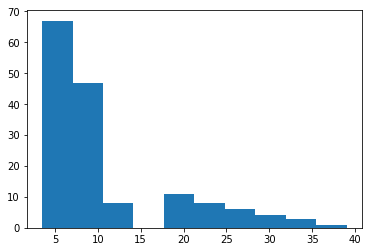

In [24]:
plt.close()
plt.hist(full_y)
plt.show()

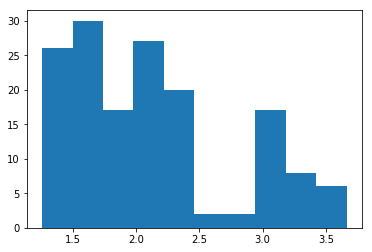

In [28]:
plt.close()
plt.hist(np.log(full_y))
plt.show()

In [30]:
print('children:',len(pheno[pheno.Age<15]),
      'young adults:', len(pheno[pheno.Age>15]))

children: 122 young adults: 33


## Extract features

In [70]:
from nilearn import datasets
parcellations = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = parcellations.scale064

In [72]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)
correlation_measure = ConnectivityMeasure(kind='correlation')

In [47]:
masker.fit_transform?

In [54]:
from scipy.io import loadmat
import h5py
# practice subject:
sub = dataset.func[0]
arrays = {}
f = h5py.File(conf)
for k, v in f.items():
    arrays[k] = np.array(v)

In [59]:
arrays['R'].shape

(29, 168)

In [73]:
time_series = masker.fit_transform(sub, confounds=arrays['R'].T)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
upper_triang_corr = sym_matrix_to_vec(correlation_matrix, discard_diagonal=True)

In [74]:
upper_triang_corr.shape

(2016,)

In [75]:
%%time
from nilearn.connectome import ConnectivityMeasure, sym_matrix_to_vec

all_features = [] # here is where we will put the data (a container)
for i,sub in enumerate(dataset.func):
    # convert confounds to readable format
    arrays = {}
    f = h5py.File(dataset.confounds[i])
    for k, v in f.items():
        arrays[k] = np.array(v)
    conf = arrays['R'].T
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=conf)
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # isolate non-redundant features
    upper_triang_corr = sym_matrix_to_vec(correlation_matrix, discard_diagonal=True)
    # add to our container
    all_features.append(upper_triang_corr)
    # keep track of status
    print('finished %s of %s'%(i+1,len(dataset.func)))

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

In [81]:
np.array(all_features).shape

(155, 2016)

In [82]:
np.savez_compressed?

In [85]:
# save data so we don't have to rerun that again
outdir = os.getcwd()
np.savez_compressed(os.path.join(outdir,'BASC064_features'),a = all_features, b = full_y)

## Create training sample to experiment with different models
* Basic model
* More balanced ages
* Weighting adults more
* Child vs adult?

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

In [32]:
StratifiedShuffleSplit?